In [2]:
import sys
python_path = ['/home/xu.chao/cantera/build/python', '/home/xu.chao/RMG-Py', '/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages', '/home/xu.chao/cantera', '/home/xu.chao/anaconda3/envs/rmg_env/lib/python37.zip', '/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7', '/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/lib-dynload', '/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/chemprop-0.0.1-py3.7.egg', '/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/descriptastorus-2.0.0.32-py3.7.egg']
sys.path.clear()
for path in python_path:
    sys.path.append(path)

In [5]:
import cantera as ct
print(ct.__file__)

import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import rmgpy
import rmgpy.data.base
import rmgpy.molecule
import rmgpy.quantity
import scipy

/home/xu.chao/cantera/build/python/cantera/__init__.py


In [3]:
base_path = 'base_original/base_modified_pt.yaml'
gas = ct.Solution(base_path, "gas")
surf_ref = ct.Interface(base_path, 'surface1', [gas])

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in cp/R detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  10.615319744584205
	Value computed using high-temperature polynomial: 10.773680323194302

  This is separate from the ipykernel package so we can avoid doing imports until
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in h/RT detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  -16.685067677440152
	Value computed using high-temperature polynomial: -16.696975757668092

  This is separate from the ipykernel package so we can avoid doing imports until
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH4OX(43), discontinu

In [4]:
# make input list mannually
inputs = [('H', 0), ('C', 4), ('C', 2), ('C', 4), ('O', 0), ('C', 2), ('C', 3), ('C', 1), ('C', 0), ('H', 1), ('O', 1),
           ('O', 2), ('C', 2), ('C', 1), ('O', 1), ('C', 4), ('C', 1), ('C', 4), ('C', 4)]

In [5]:
for i in range(1, surf_ref.n_species):
    print(surf_ref.species(i), inputs[i-1])

<Species HX(21)> ('H', 0)
<Species CO2X(22)> ('C', 4)
<Species COX(23)> ('C', 2)
<Species CH4X(24)> ('C', 4)
<Species OX(25)> ('O', 0)
<Species CH2X(26)> ('C', 2)
<Species CH3X(27)> ('C', 3)
<Species CHX(28)> ('C', 1)
<Species CX(29)> ('C', 0)
<Species H2X(30)> ('H', 1)
<Species OHX(31)> ('O', 1)
<Species H2OX(32)> ('O', 2)
<Species CHOX(33)> ('C', 2)
<Species CHOX(234)> ('C', 1)
<Species CH3O_X(45)> ('O', 1)
<Species CH4OX(43)> ('C', 4)
<Species C2H3X(244)> ('C', 1)
<Species CH2O_X(46)> ('C', 4)
<Species C2H6X(65)> ('C', 4)


In [37]:
species_dict = rmgpy.data.base.Database().get_species('/home/xu.chao/sketches/cpox_sim/rmg_models/binding_energies/4.0_c-5.500o-4.000/chemkin/species_dictionary.txt',resonance=False)

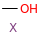

In [28]:
species_dict['CH4OX(43)'] #10 models

In [30]:
species_dict['C2H3X(244)']

In [25]:
species_dict['CH3O_X(45)']

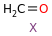

In [36]:
species_dict['CH2O_X(46)'] # 4 models

In [38]:
species_dict['C2H6X(65)'] # 2 models

In [9]:
# add bms
def get_Ea_from_E0_dH(E0, dHrxn, w0=1e9):
        """
        Return the activation energy in J/kmol corresponding to the given
        E0, enthalpy of reaction `dHrxn`, and w0, all in J/kmol.
        """
        E0 = float(E0)
        w0 = max(w0, 2*E0)
        assert w0 >= 2*E0, f"seems to work best when w0 > 2*Eo = {2*E0/1e6:.1f} kJ/mol, but w0={w0/1e6:.1f} kJ/mol"
        
        if E0 == dHrxn == 0:
            return 0
        if dHrxn < -4 * E0:
            return 0.0
        elif dHrxn > 4 * E0:
            return dHrxn
        else:
            Vp = 2 * w0 * (2 * w0 + 2 * E0) / (2 * w0 - 2 * E0)
            return (w0 + dHrxn / 2.0) * (Vp - 2 * w0 + dHrxn) ** 2 / (Vp ** 2 - (2 * w0) ** 2 + dHrxn ** 2)

def get_E0_from_Ea_dH(i, Ea, dHrxn, w0=1e9, plot=False):
    """
    Return the E0 in J/kmol corresponding to the given Ea and dHrxn and w0 in J/kmol.
    """
#     if Ea <= dHrxn:
#         E0 = 0
#         print(f"Assuming E0=0 because barrier Ea={Ea/1e6:.1f} < dHrxn={dHrxn/1e6:.1f} kJ/mol")
#     else:
    def f(E0):
        return Ea - get_Ea_from_E0_dH(E0, dHrxn, w0=w0)
    E0_guess = Ea*.5 if dHrxn>0 else max(Ea*8,30e6)
    E0 = scipy.optimize.fsolve(f, E0_guess)[0]
        #print(f"E0 = {E0}")
        
    if plot:
        plt.ioff()
        plt.clf()
        dHs = np.linspace(min(-5*E0,dHrxn),max(5*E0,dHrxn))
        Eas = np.vectorize(lambda dH: get_Ea_from_E0_dH(E0, dH, w0=w0))(dHs)
        plt.plot(dHs/1e6, Eas/1e6)
        plt.plot(dHrxn/1e6, Ea/1e6, 'ro')
        plt.plot(0,E0/1e6,'bx')
        plt.text(0,E0/1e6,f'$E_0={E0/1e6:.1f}$ kJ/mol')
        plt.title('reaction {}'.format(i))
        plt.xlabel('$\Delta H_{rxn}$ (kJ/mol)')
        plt.ylabel('$E_a$ (kJ/mol)')
        plt.show()
    
    if not np.isclose(Ea, get_Ea_from_E0_dH(E0, dHrxn), rtol=0.002):
        print(f"Warning: {Ea} not close to {get_Ea_from_E0_dH(E0, dHrxn)}")
        
    return E0

In [60]:
base_path = 'base_original/base_modified_pt.yaml'
gas = ct.Solution(base_path, "gas")
surf = ct.Interface(base_path, 'surface1', [gas])

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in cp/R detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  10.615319744584205
	Value computed using high-temperature polynomial: 10.773680323194302

  This is separate from the ipykernel package so we can avoid doing imports until
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in h/RT detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  -16.685067677440152
	Value computed using high-temperature polynomial: -16.696975757668092

  This is separate from the ipykernel package so we can avoid doing imports until
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH4OX(43), discontinu

In [61]:
with open(base_path, 'r') as f:
    model = yaml.load(f, Loader=yaml.FullLoader)

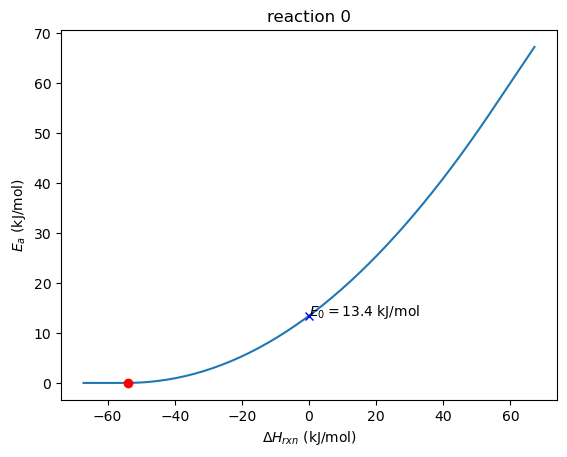

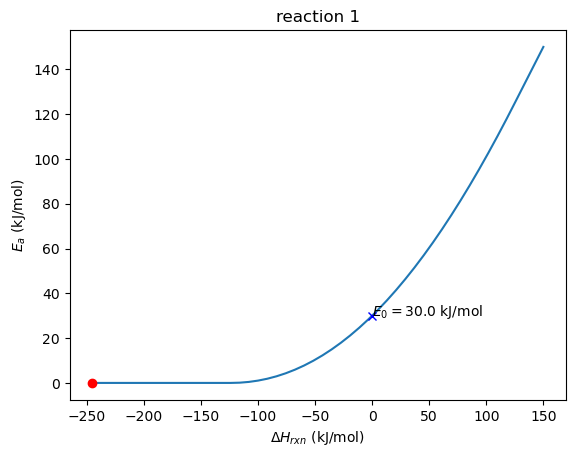

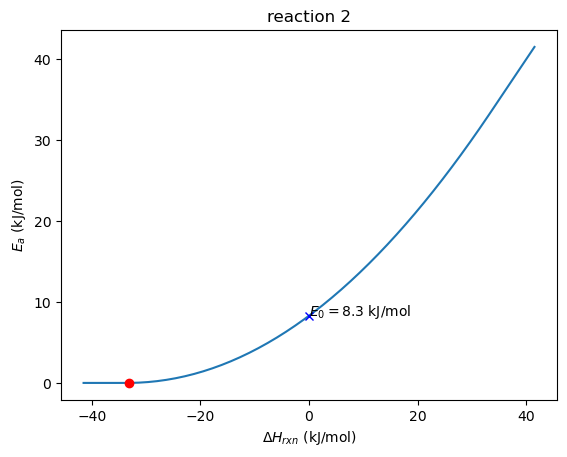

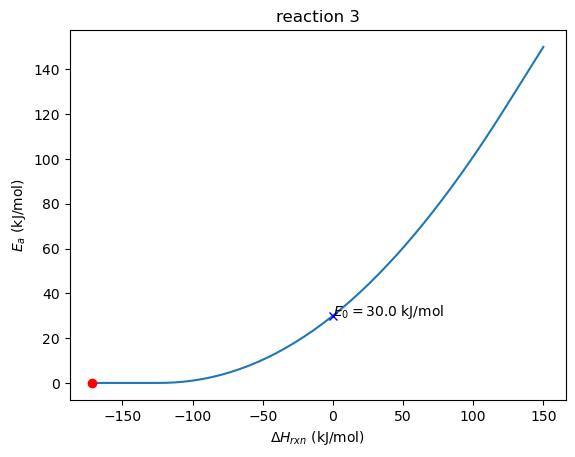

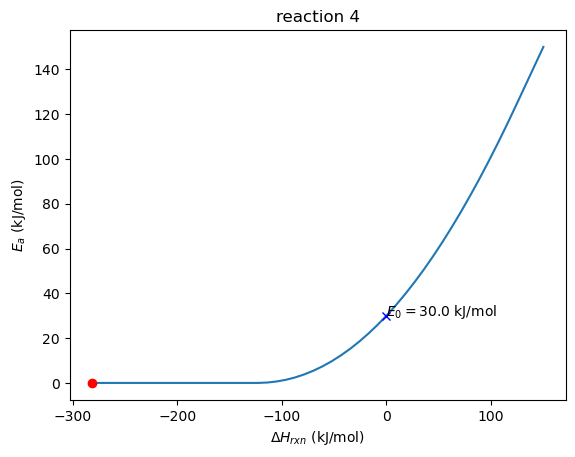

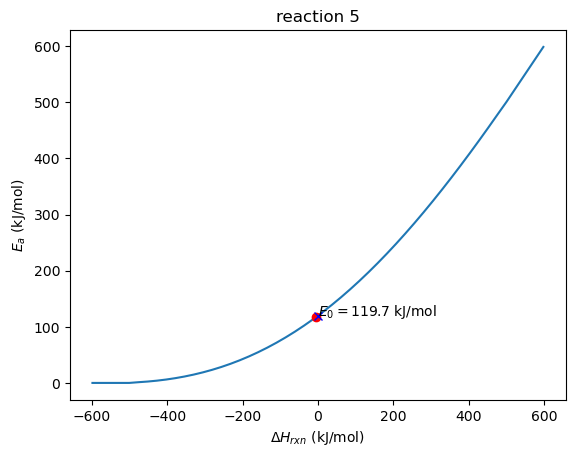

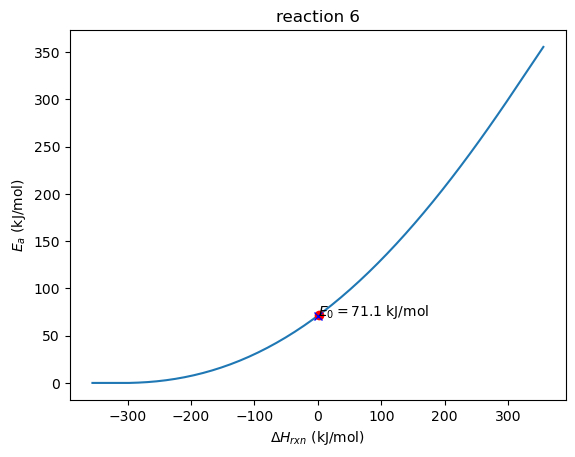

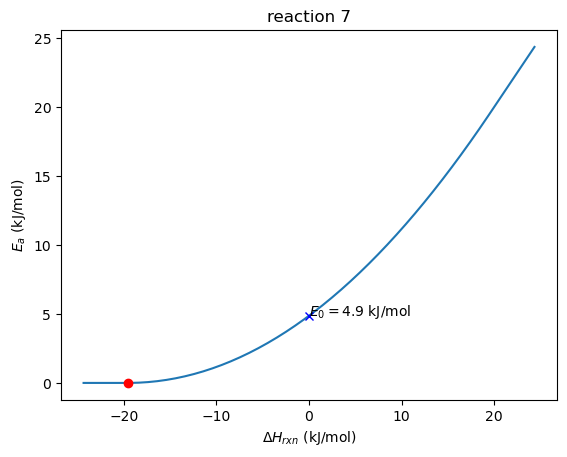

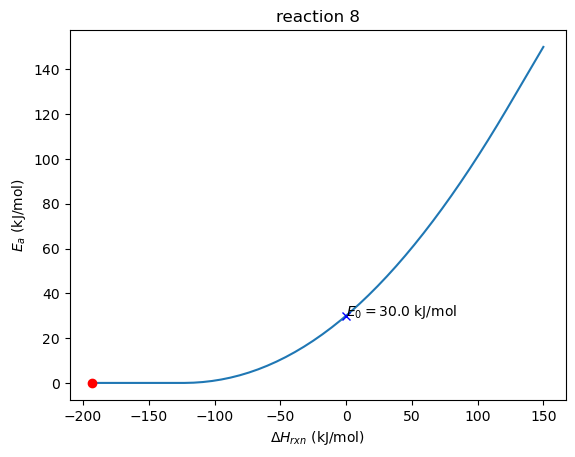

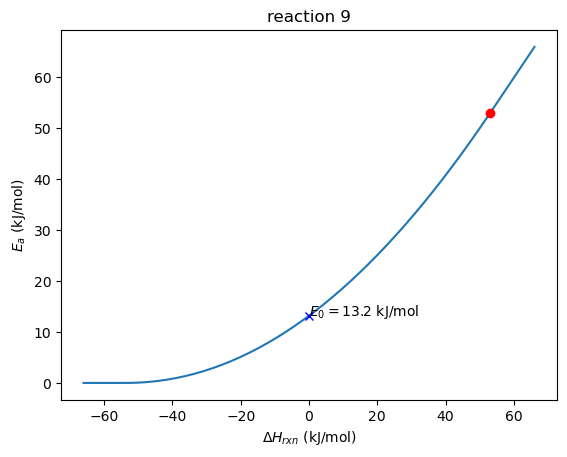

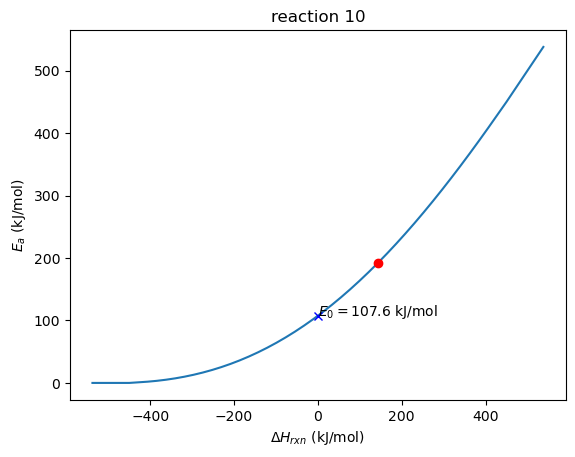

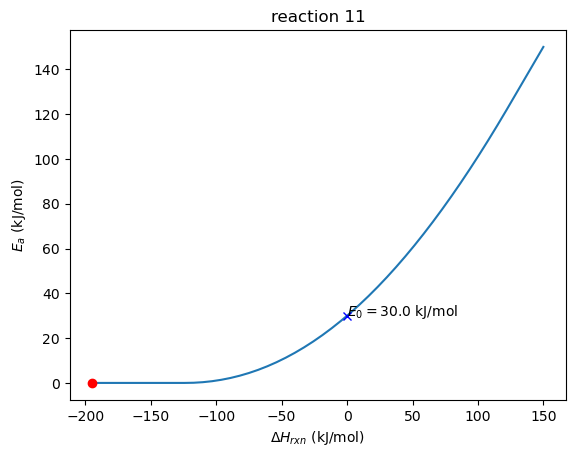

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


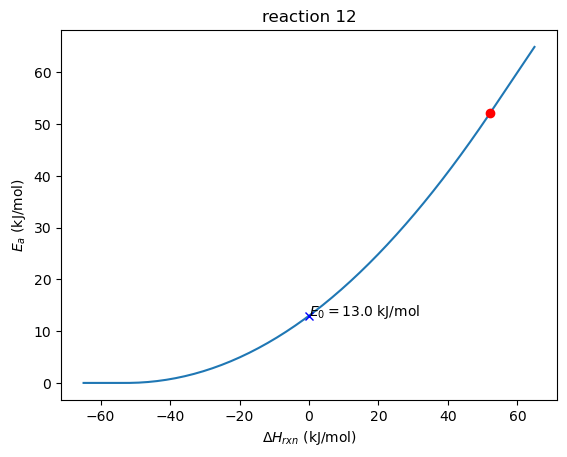

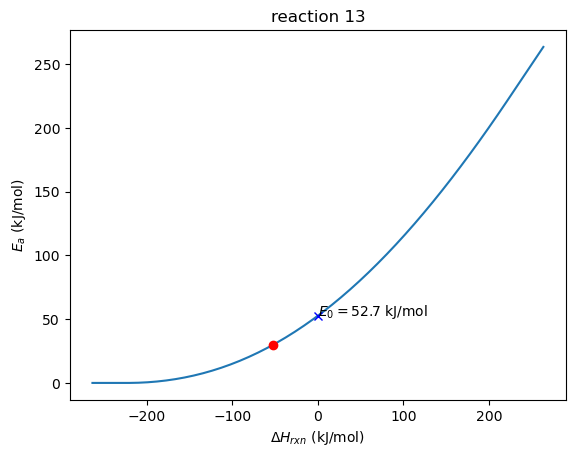

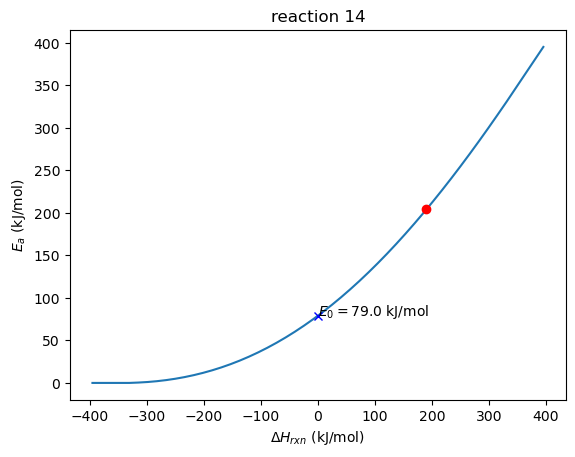

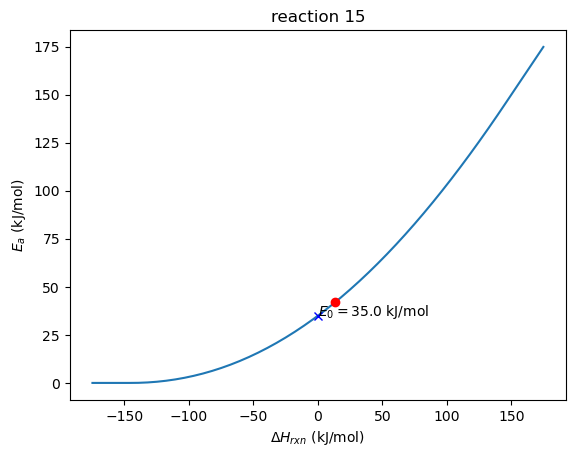

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


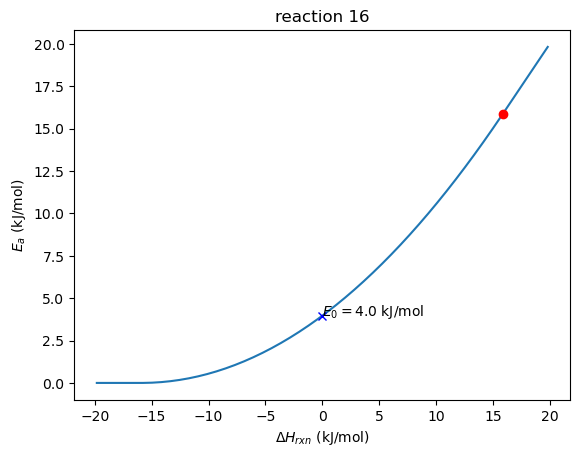

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


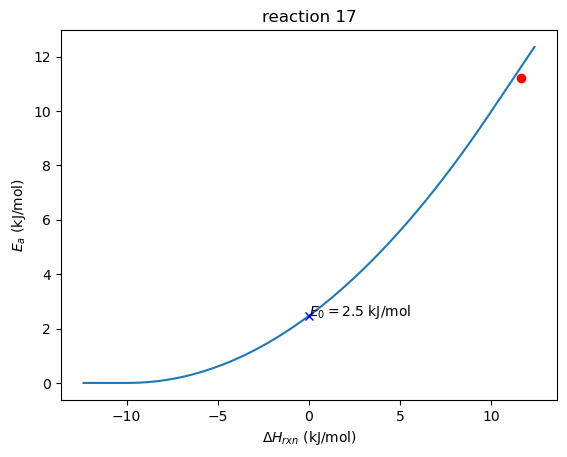

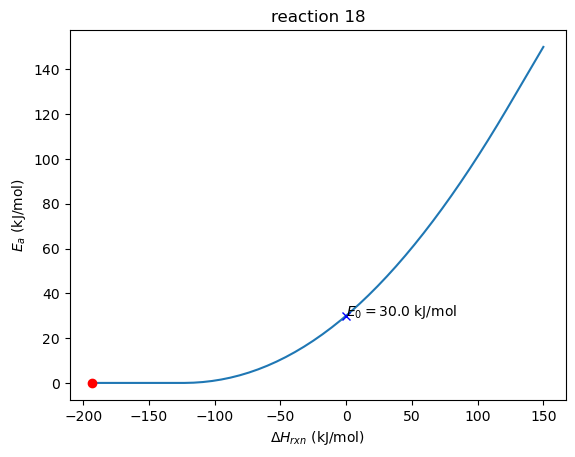

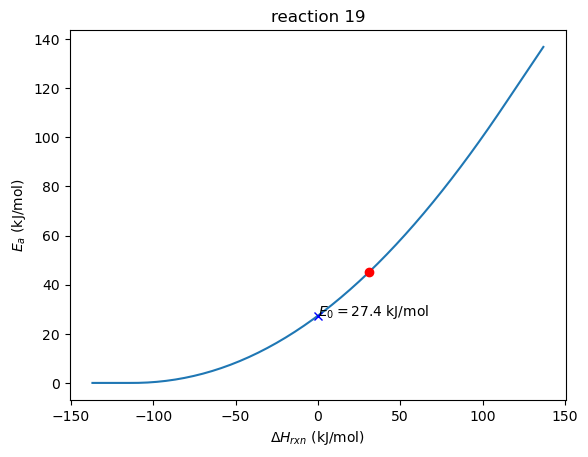

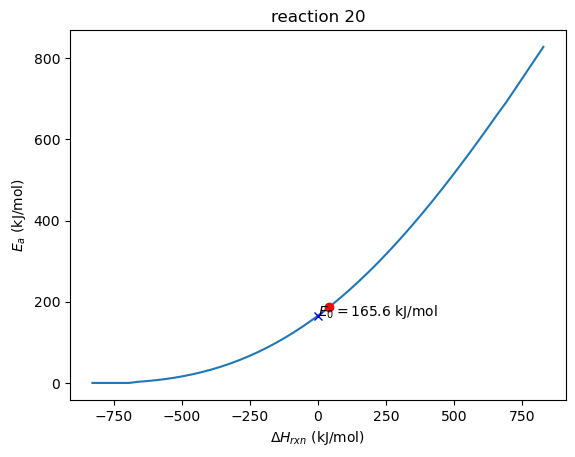

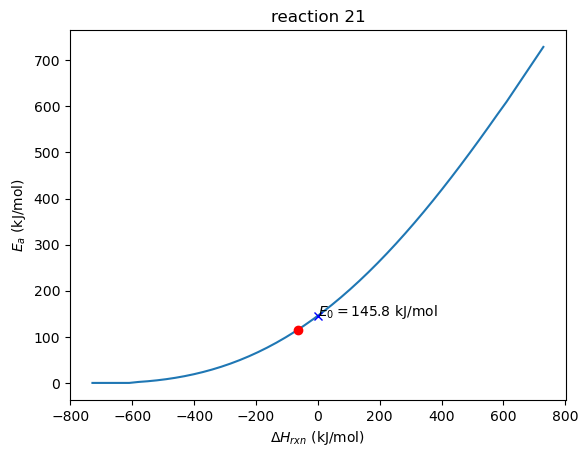

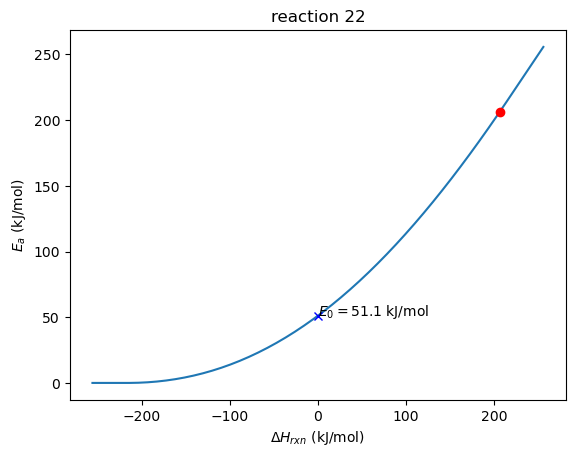

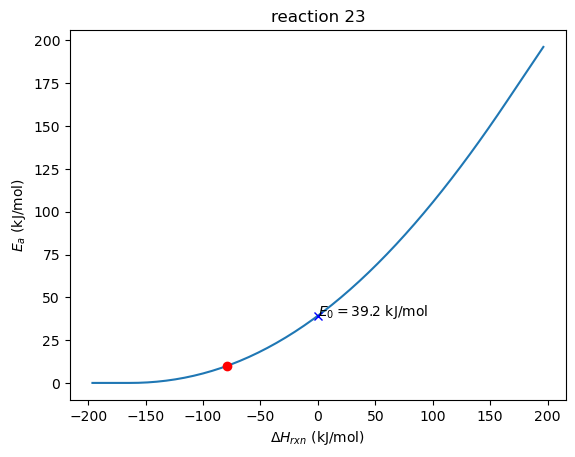

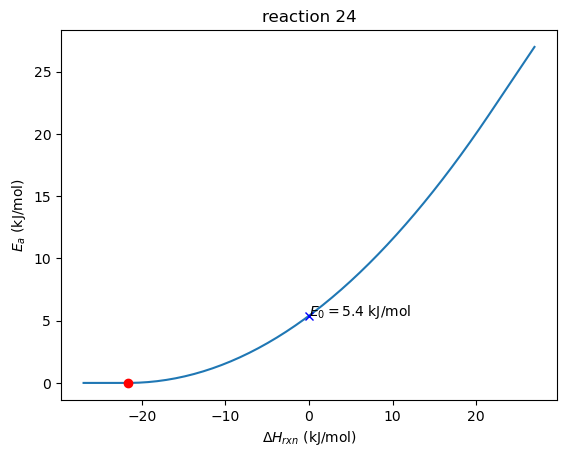

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


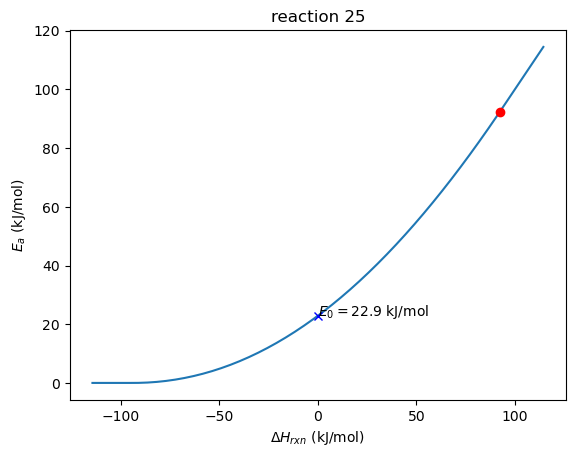

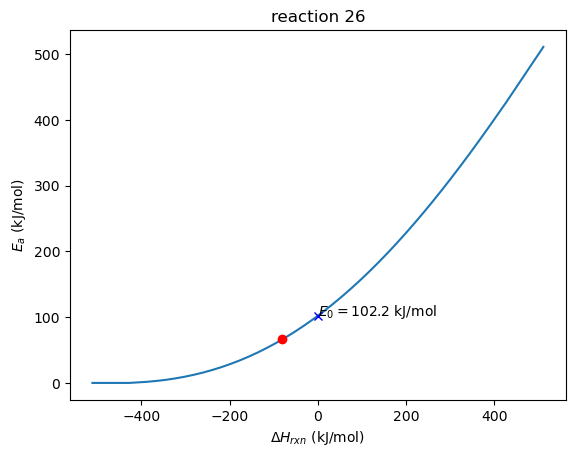

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


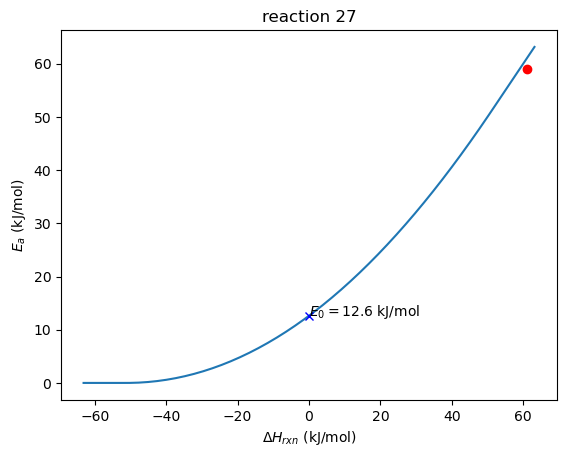

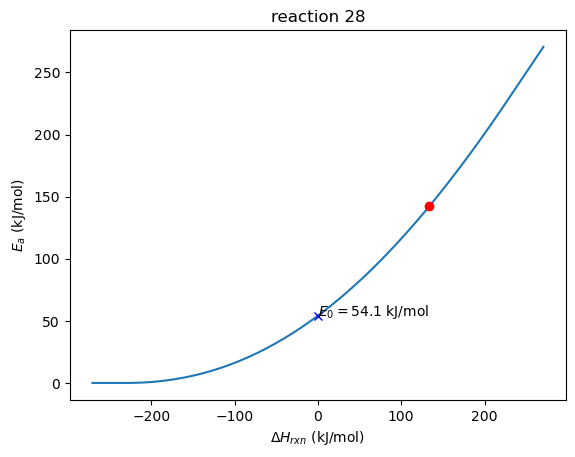

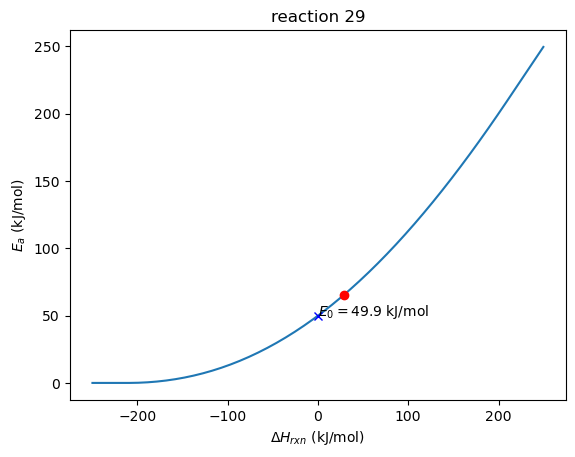

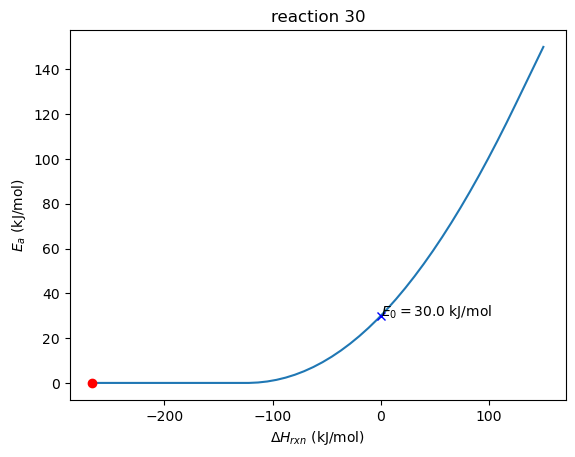

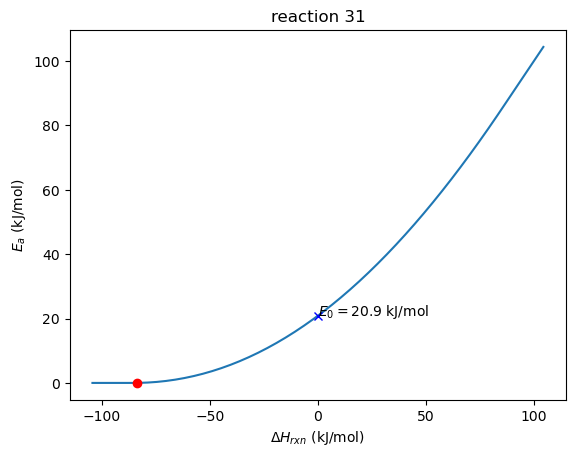

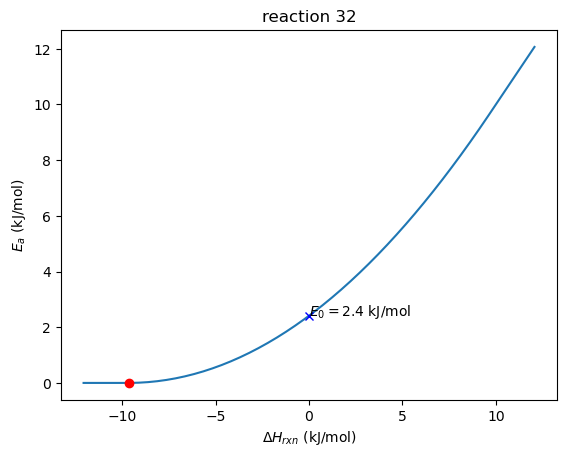

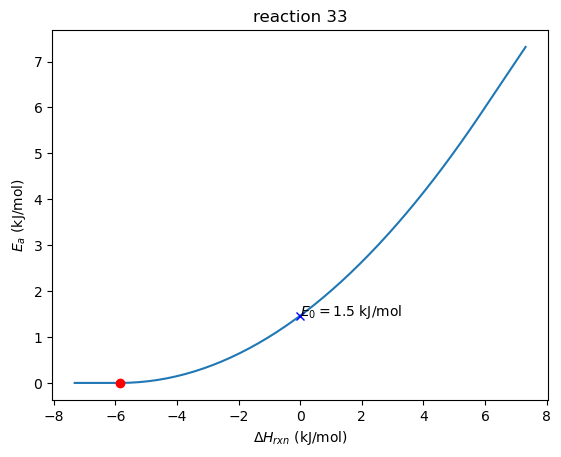

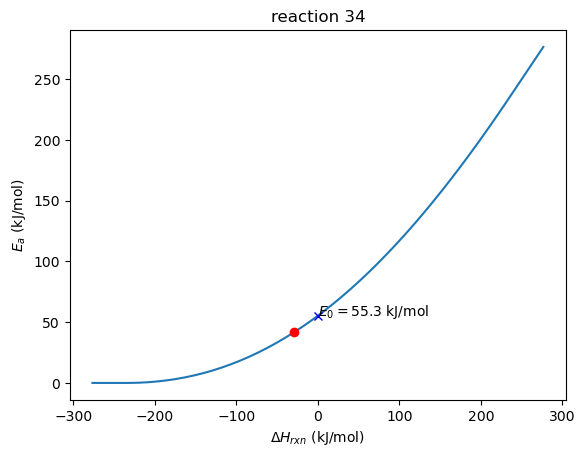

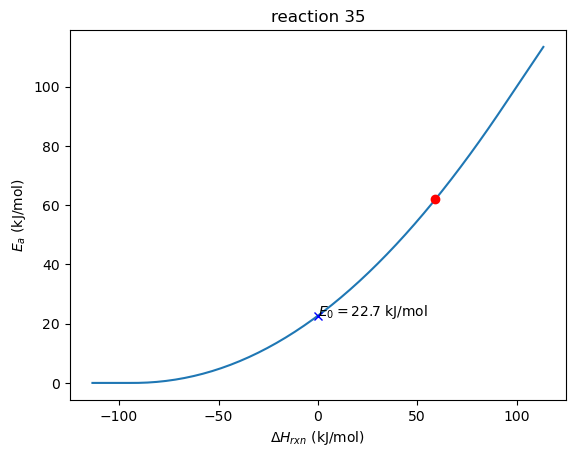

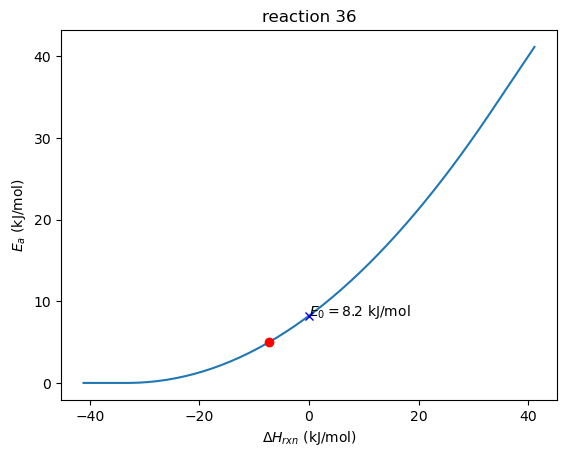

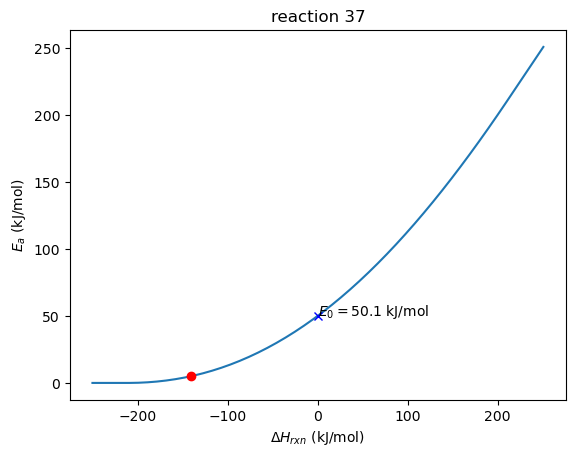

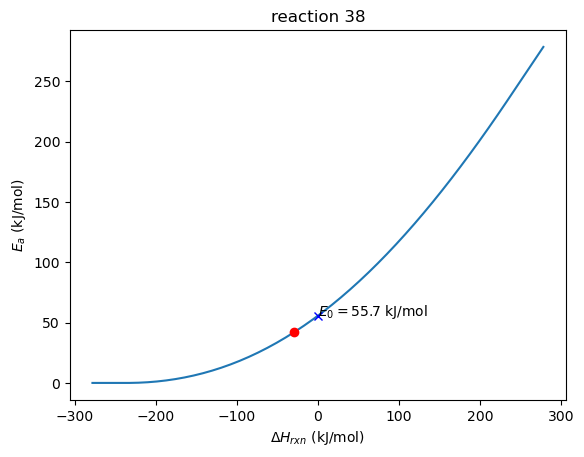

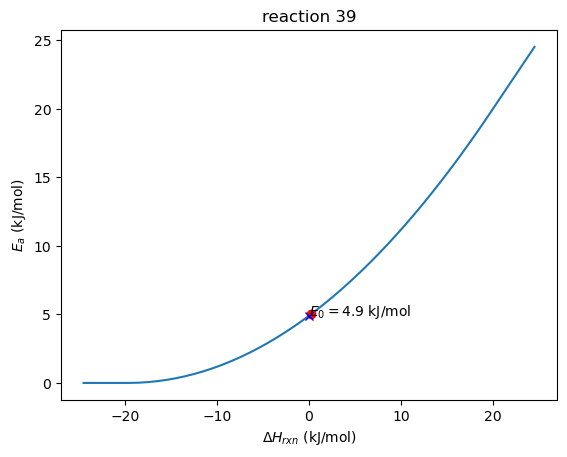

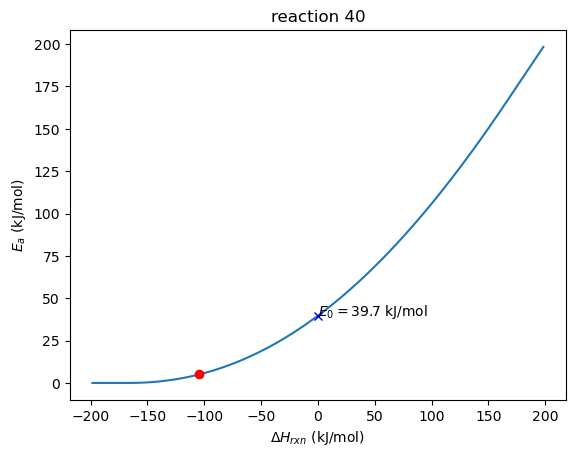

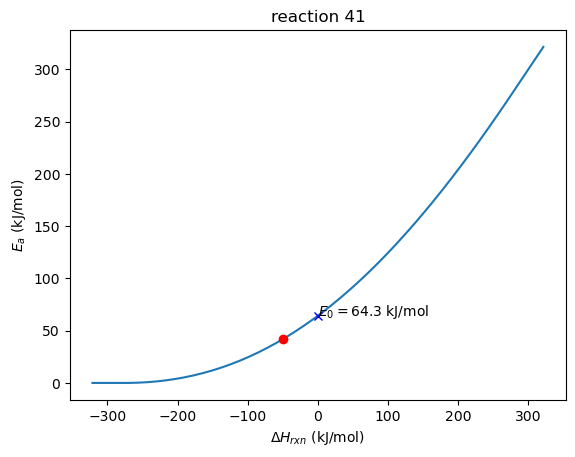

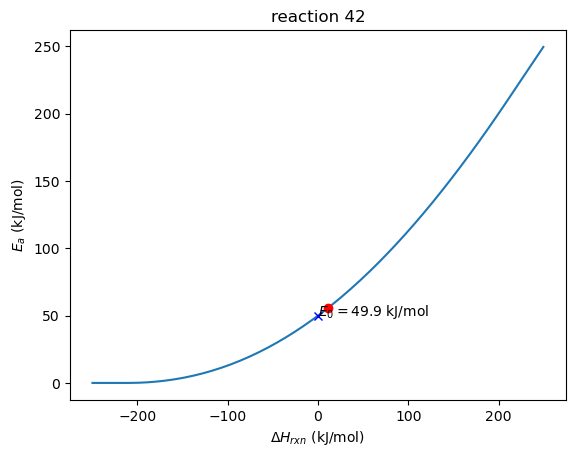

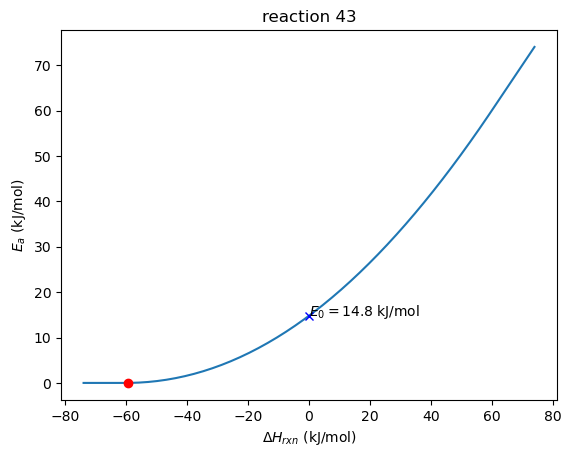

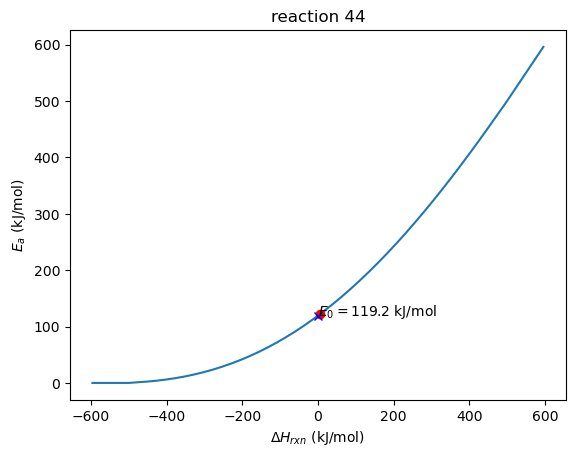

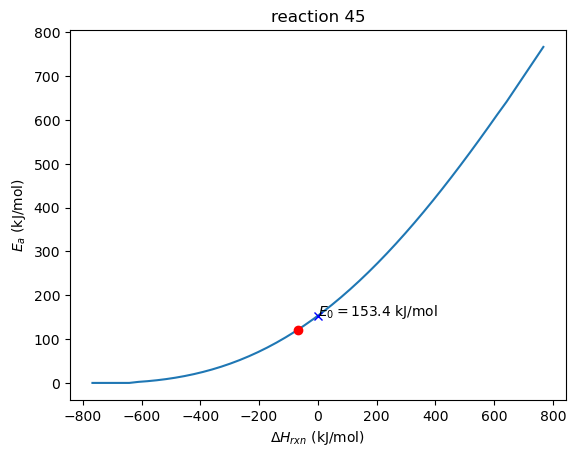

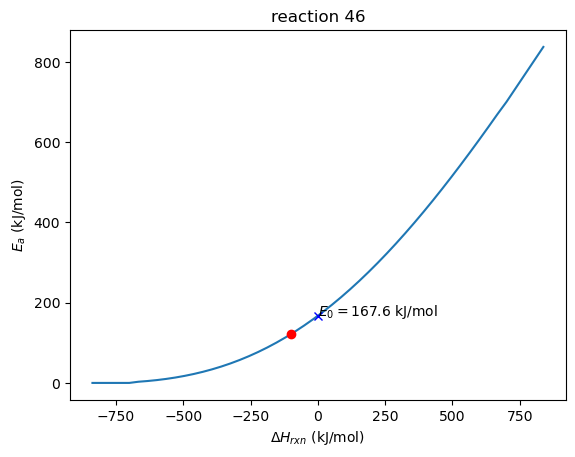

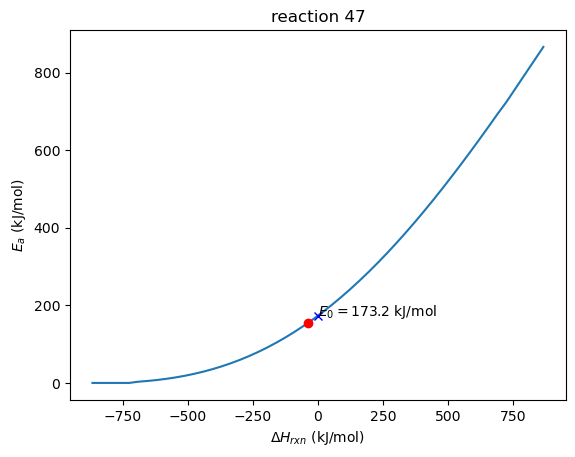

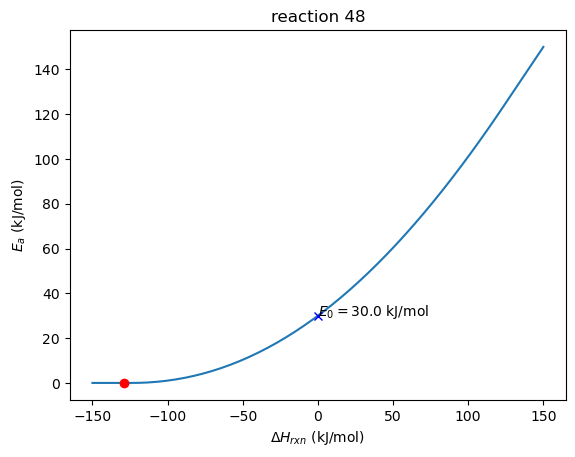

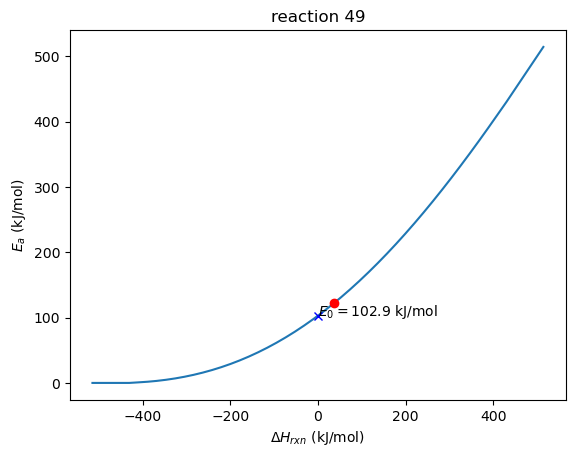

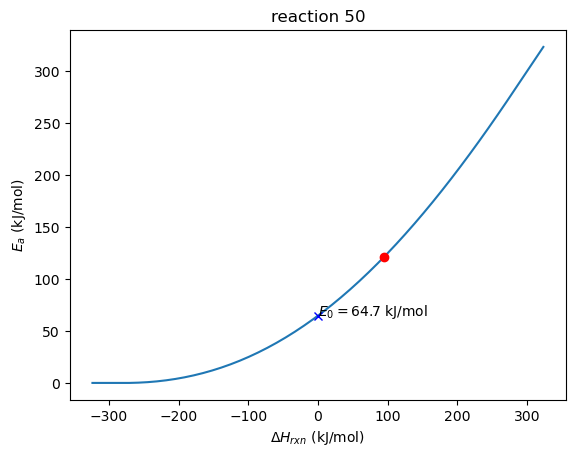

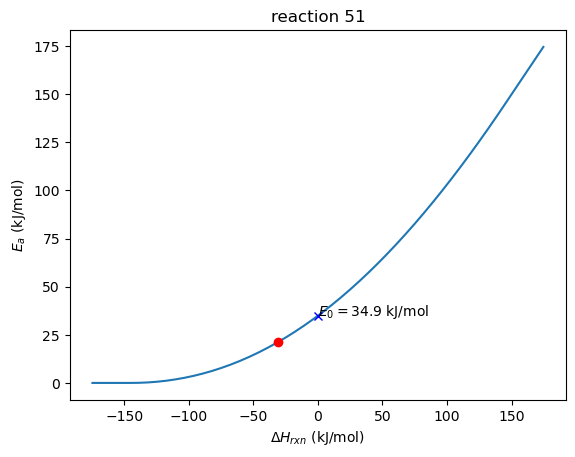

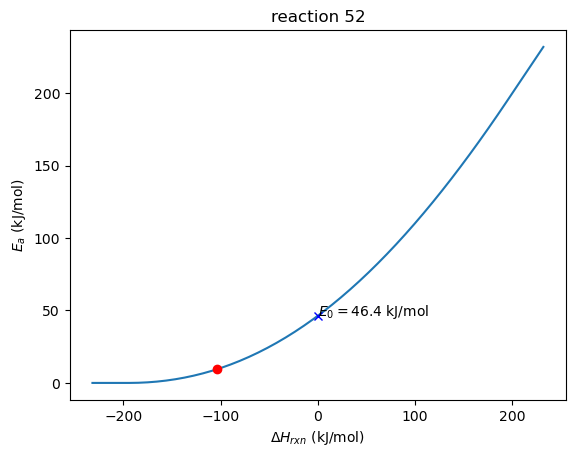

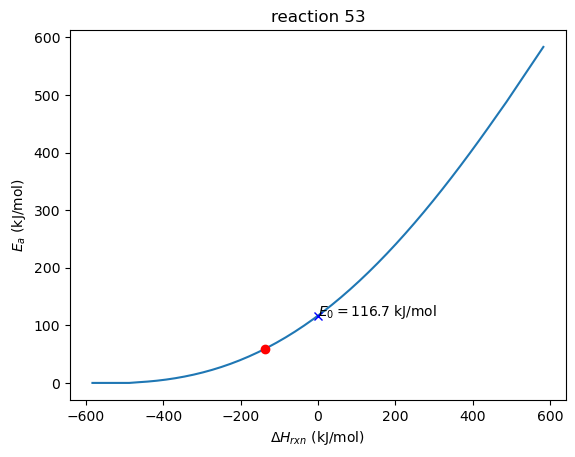

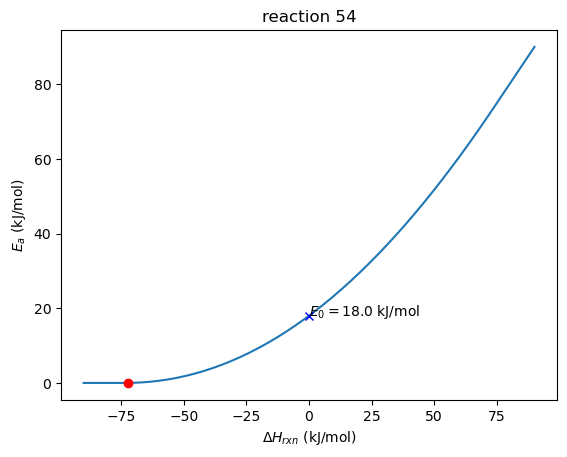

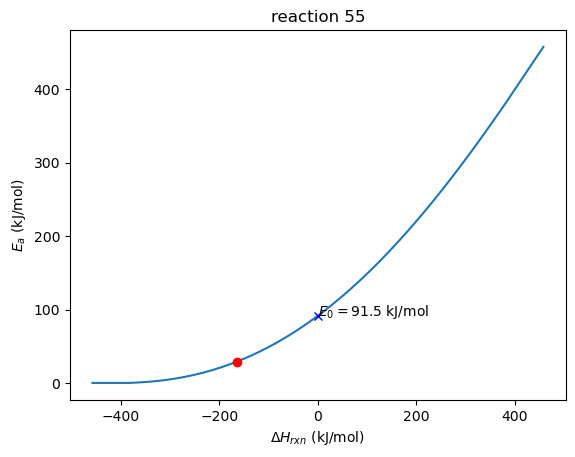

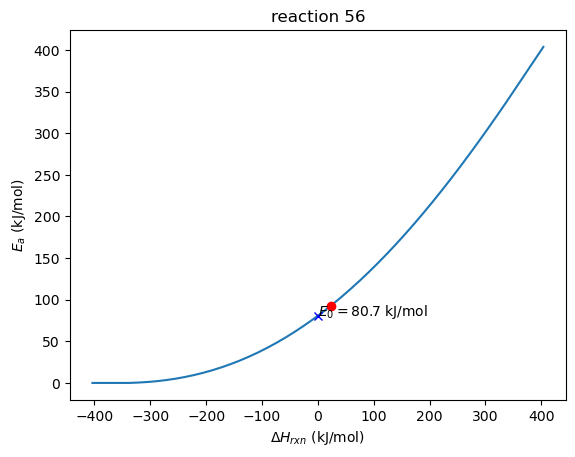

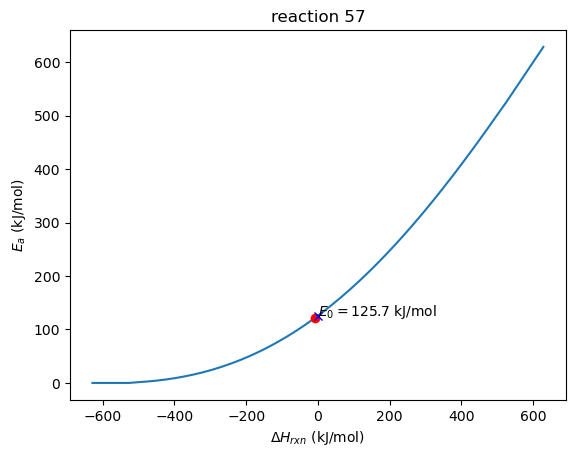

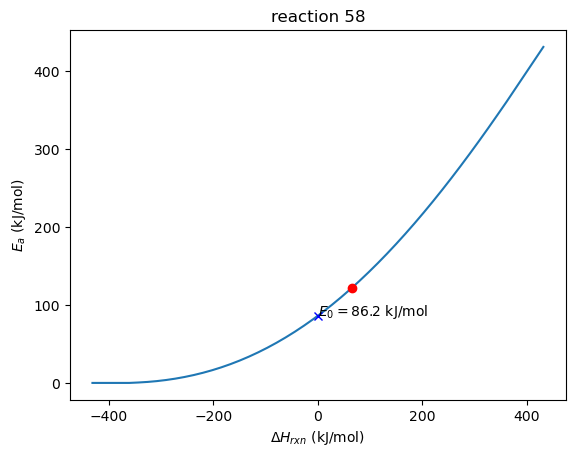

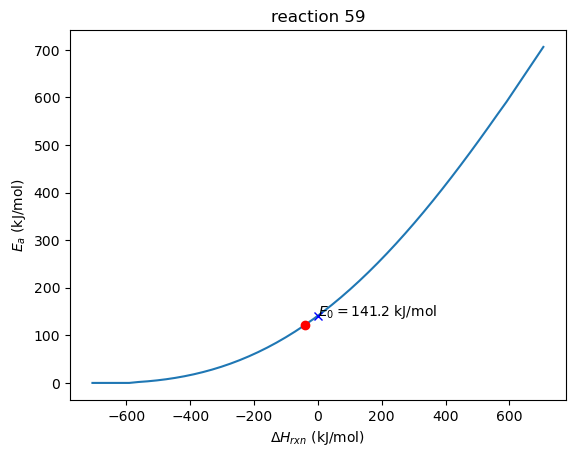

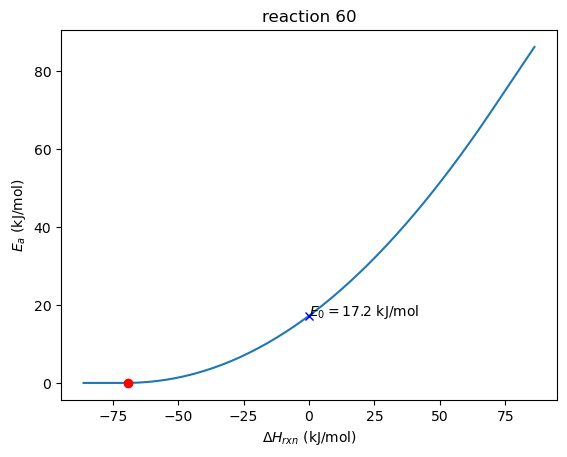

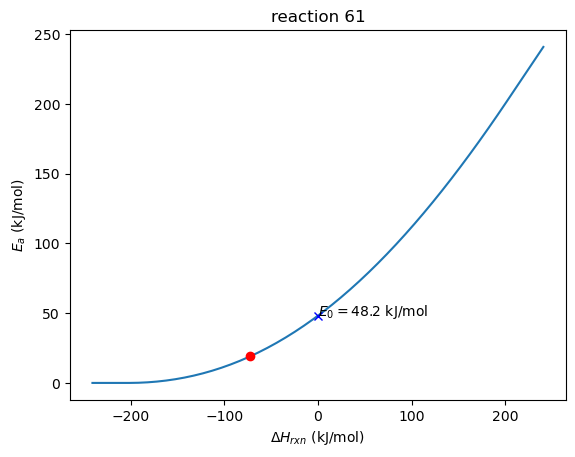

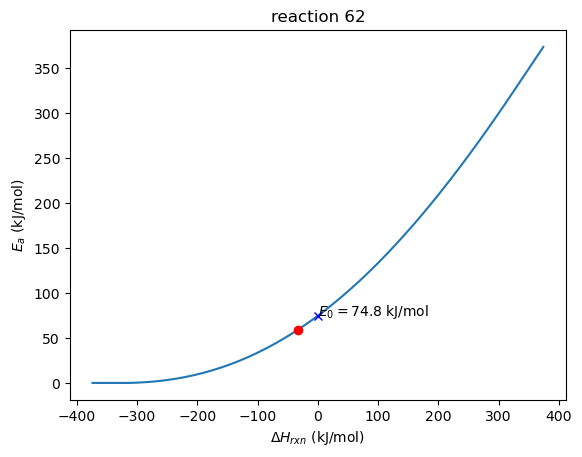

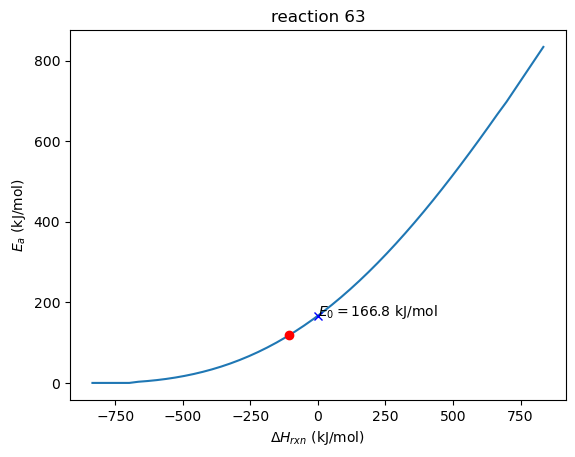

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


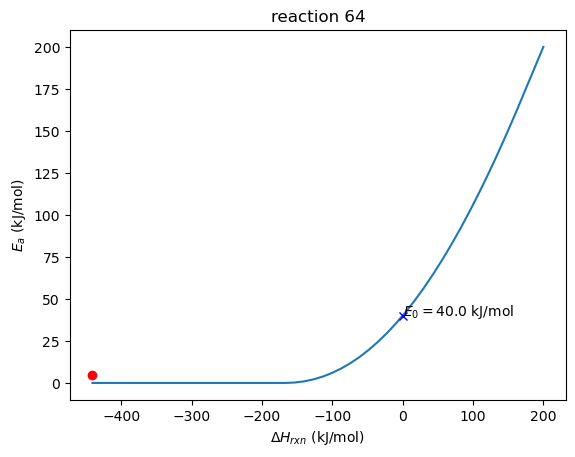

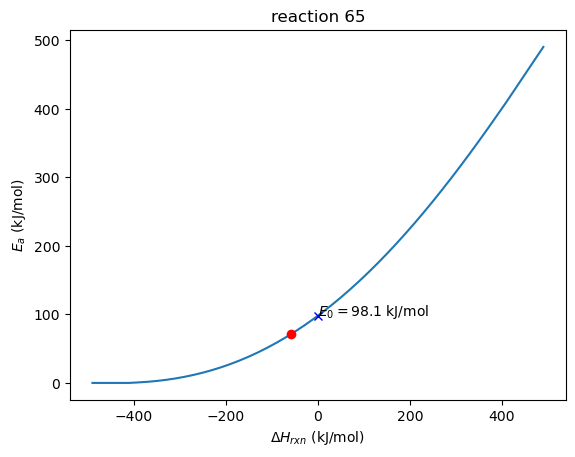

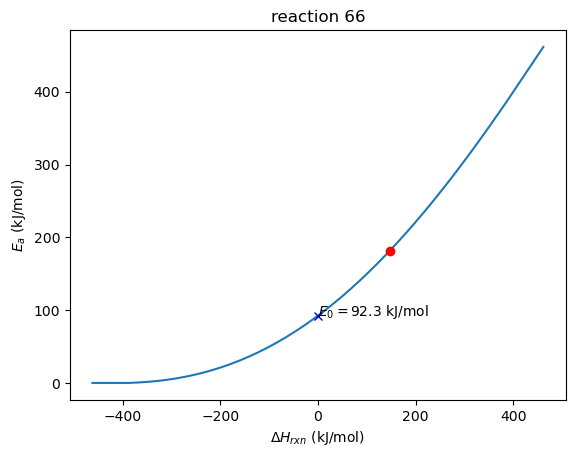

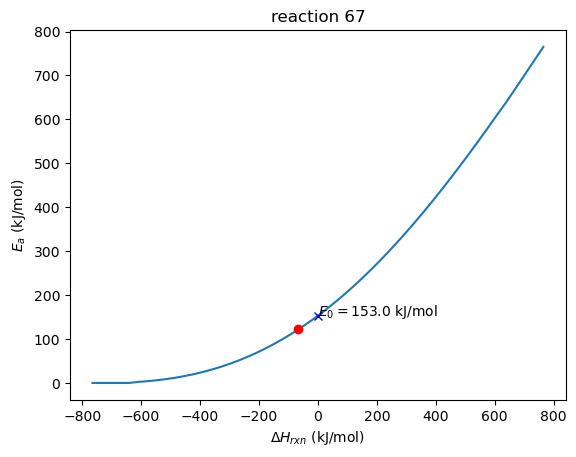

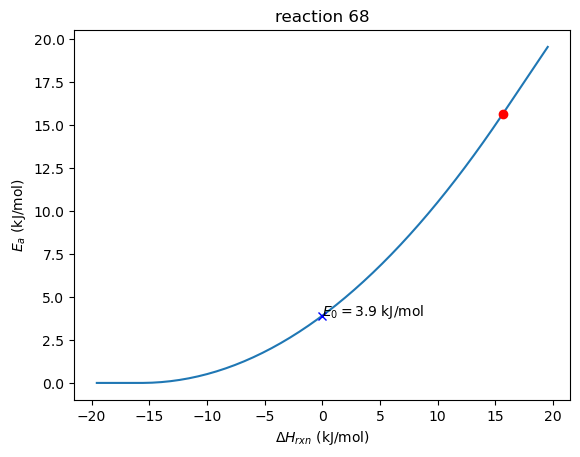

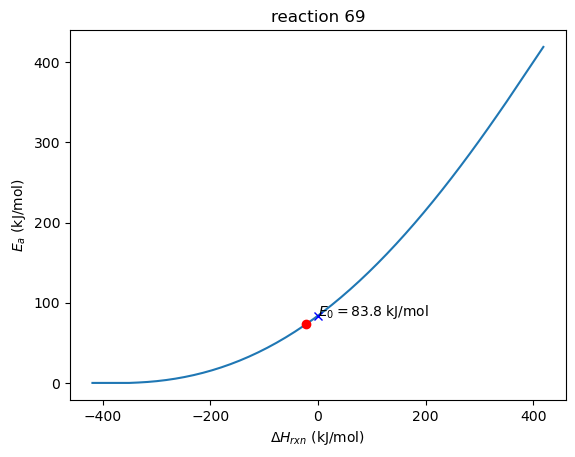

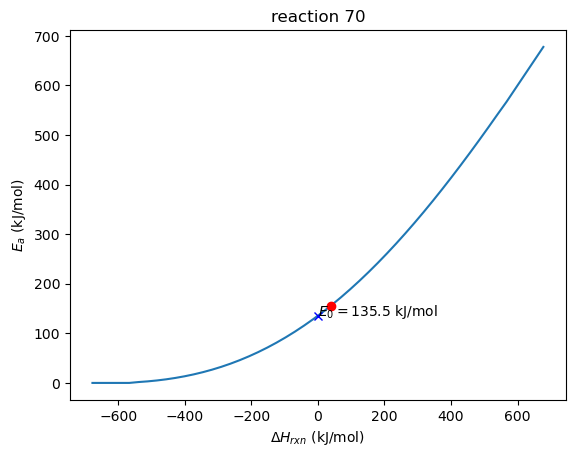

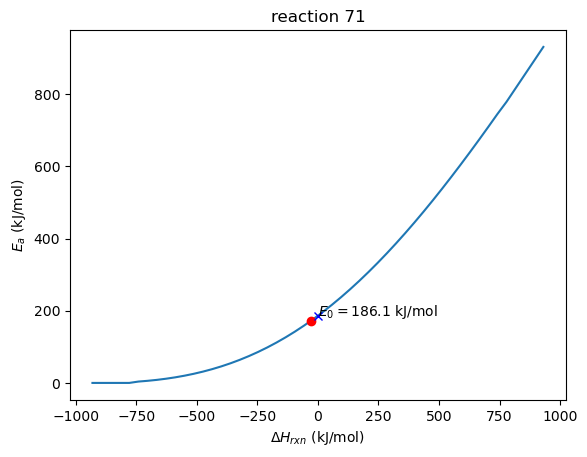

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


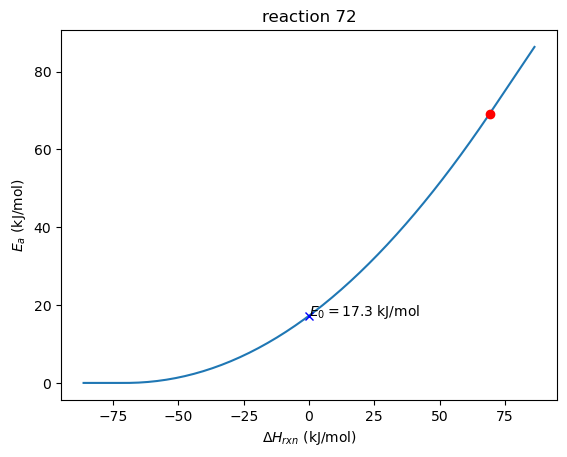

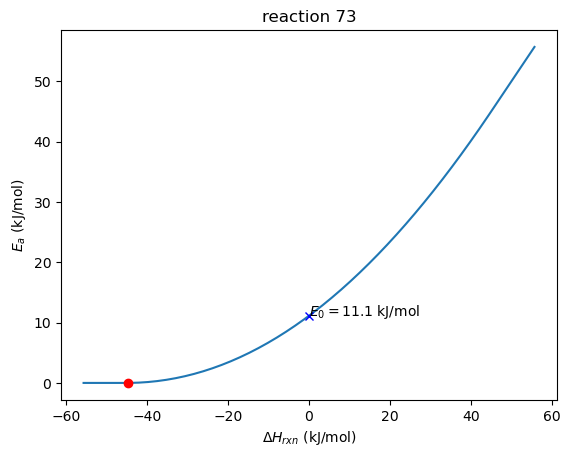

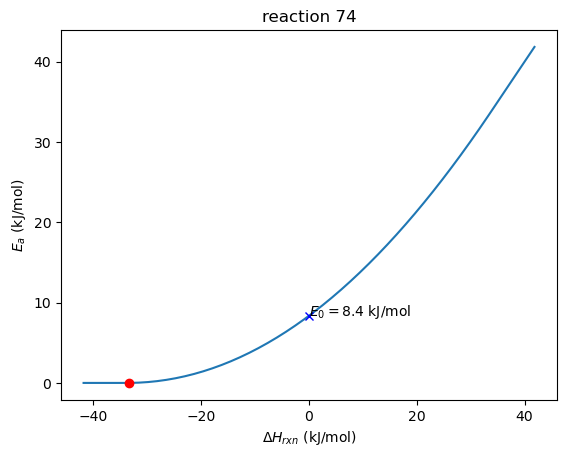

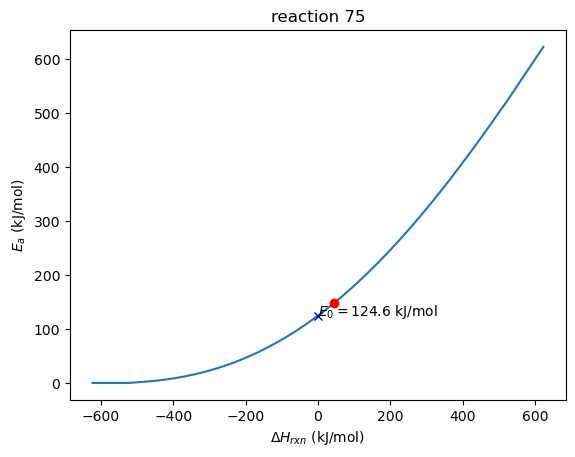

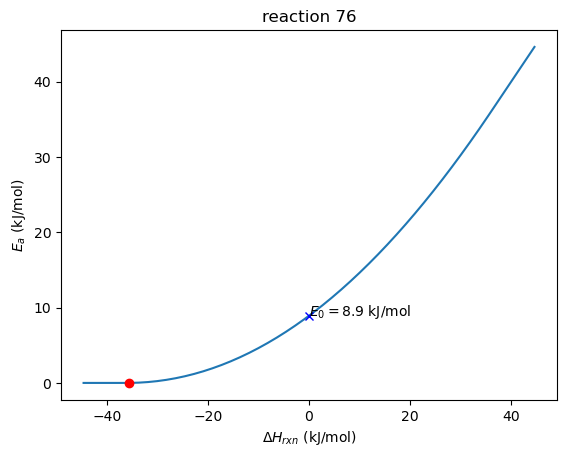

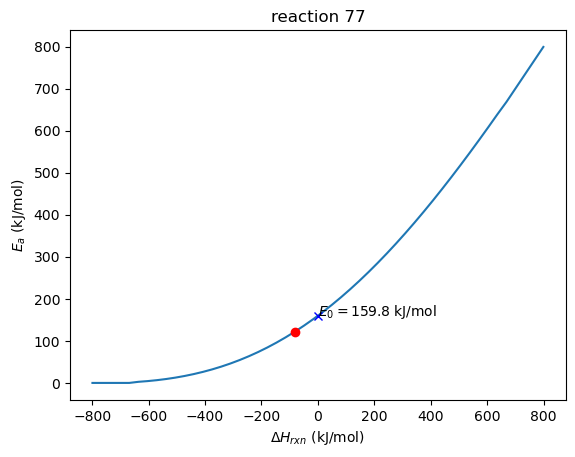

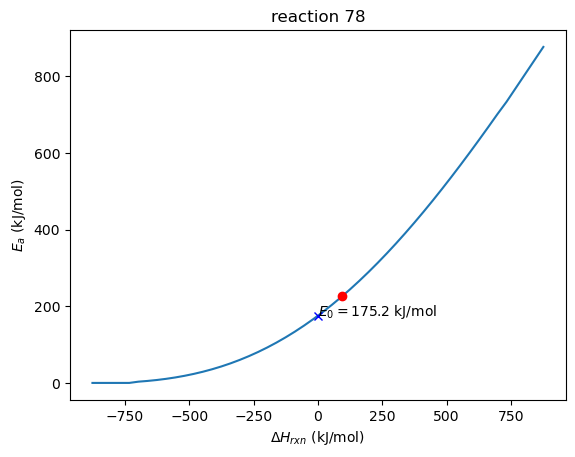

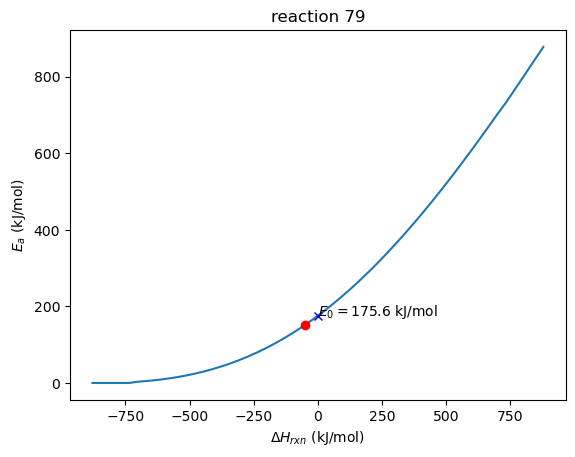

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


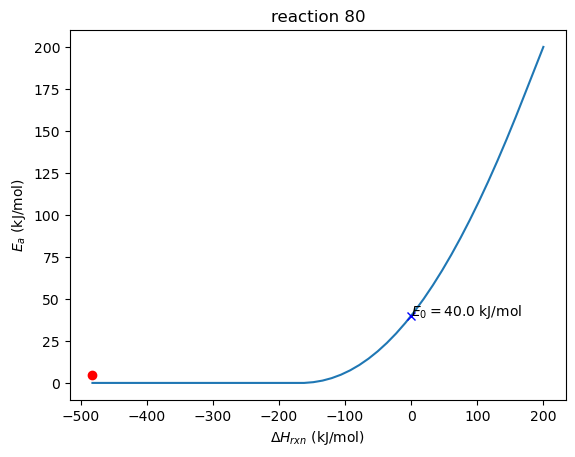

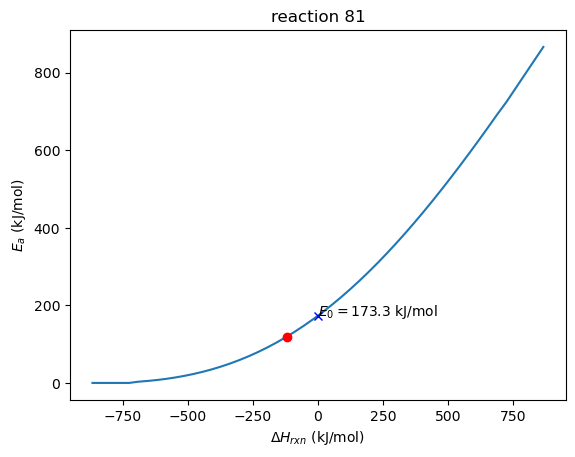

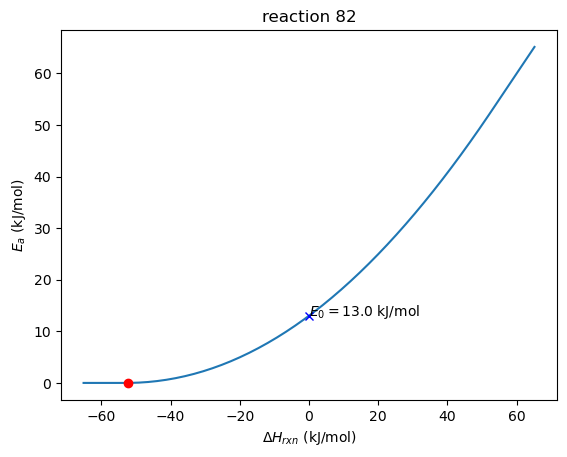

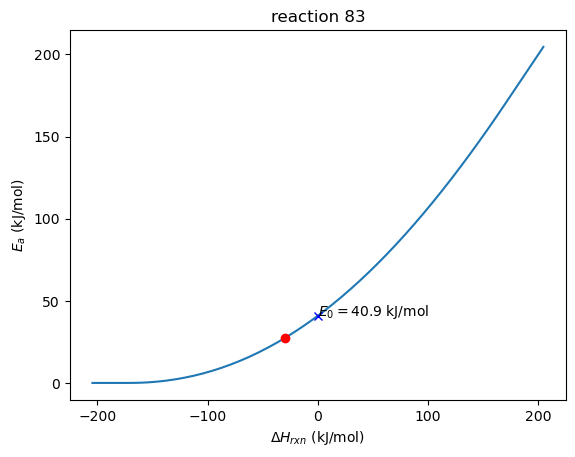

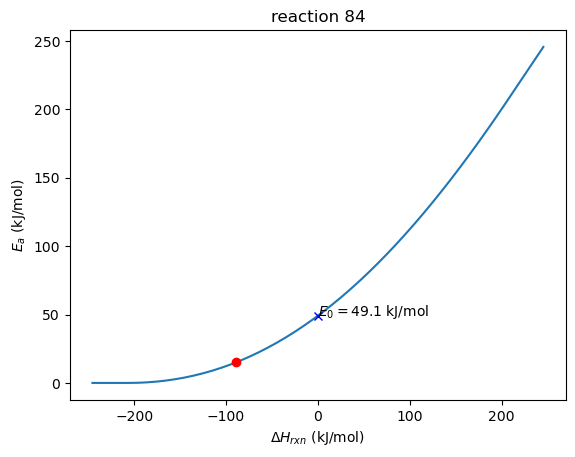

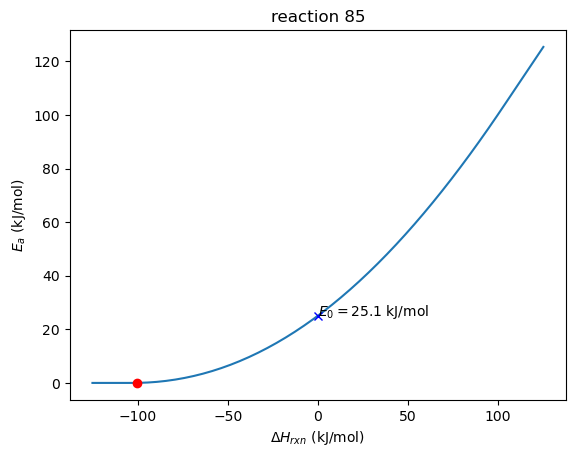

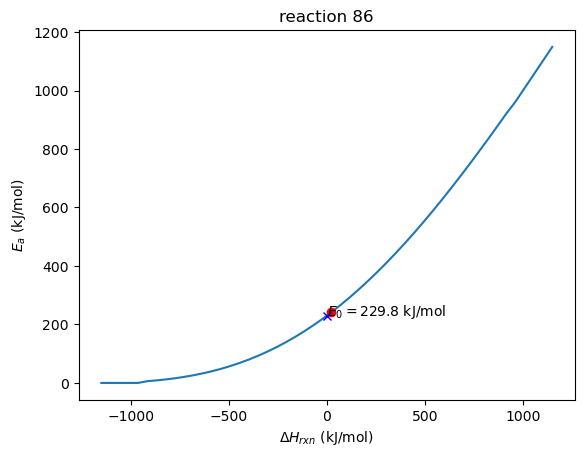

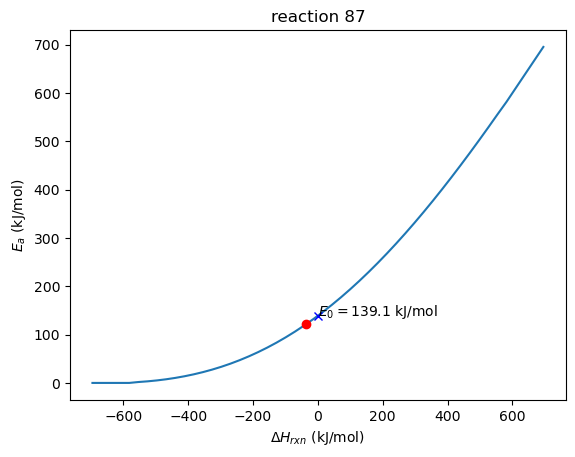

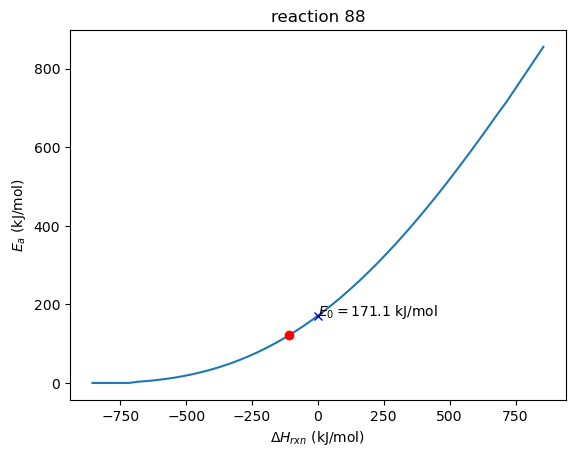

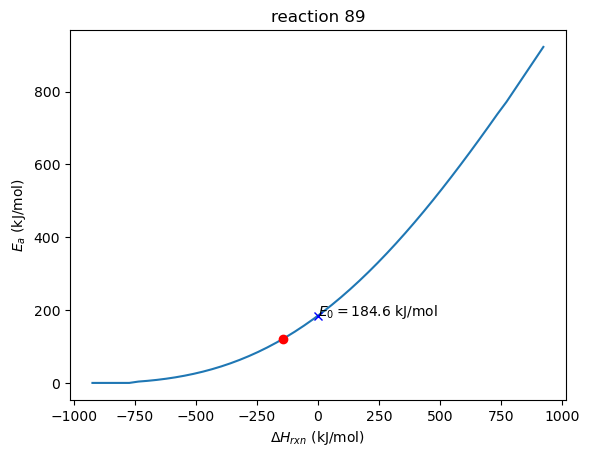

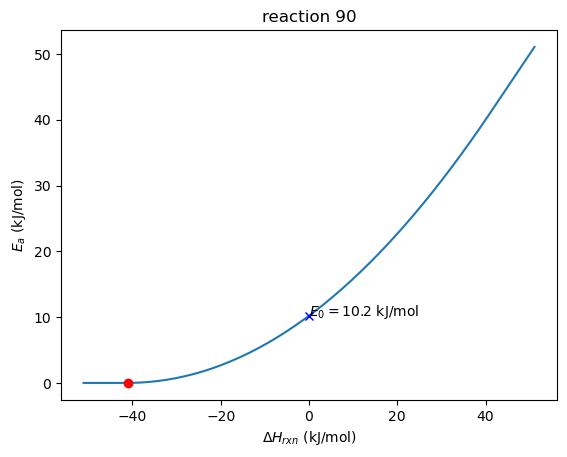

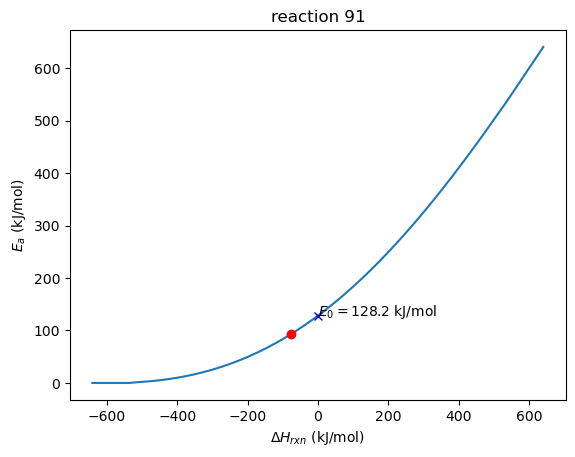

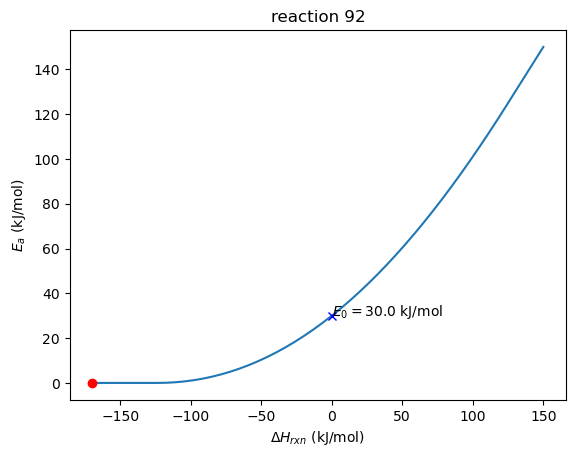

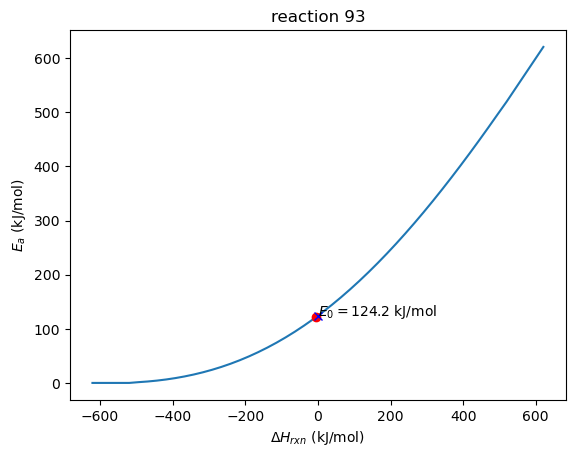

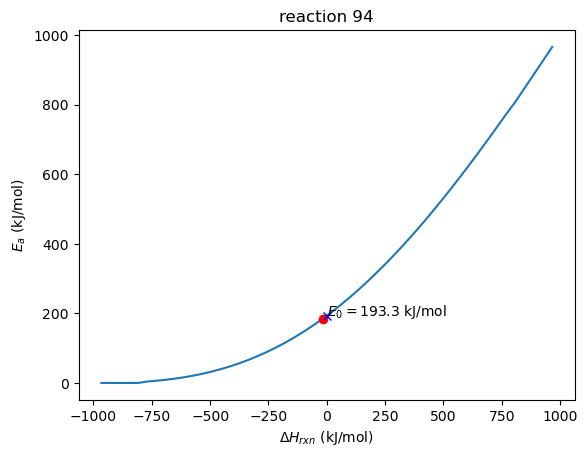

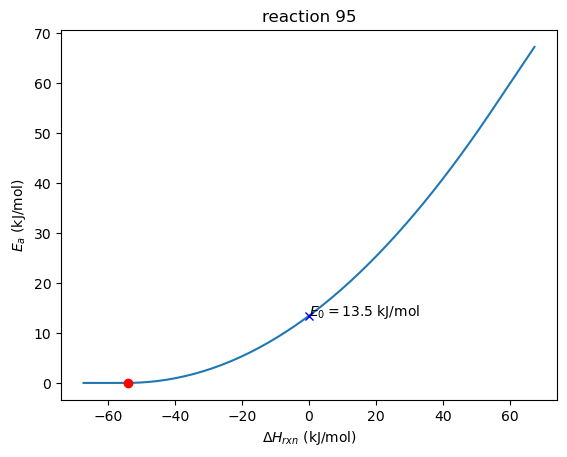

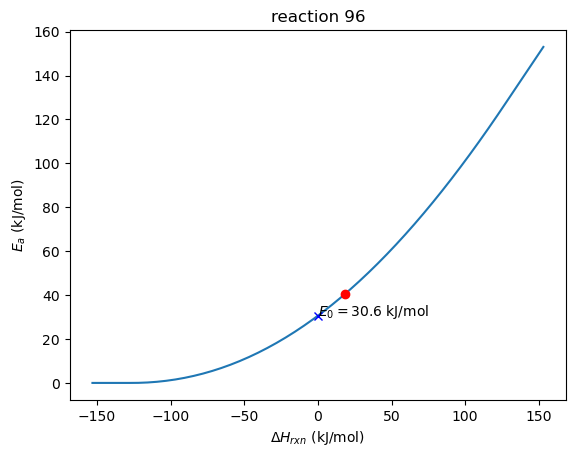

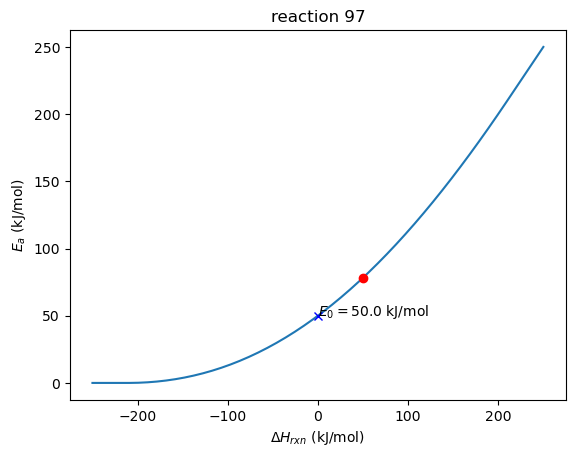

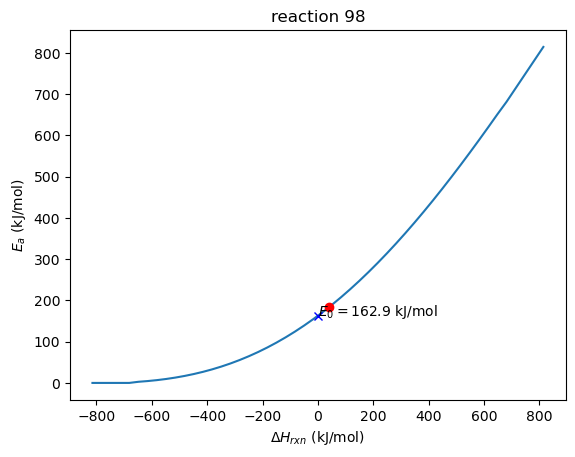

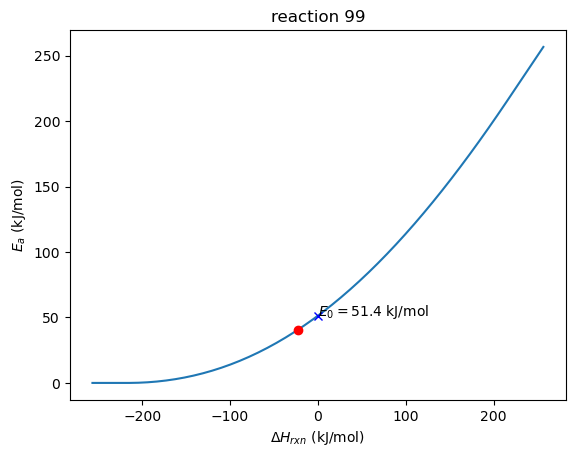

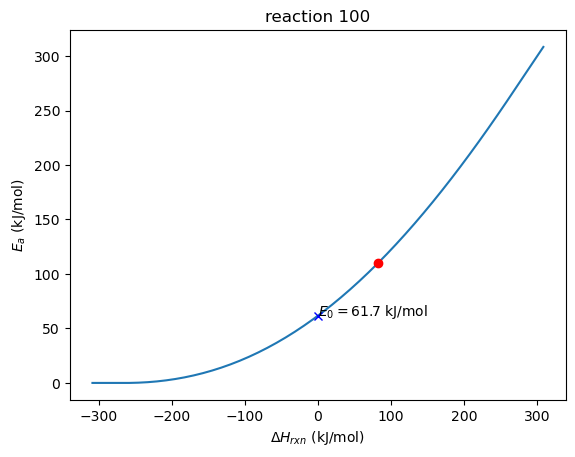

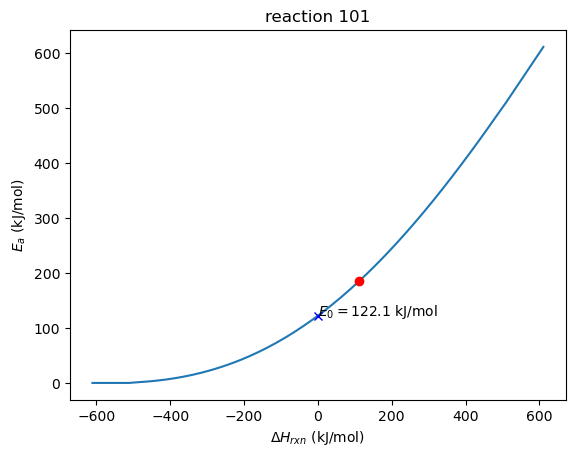

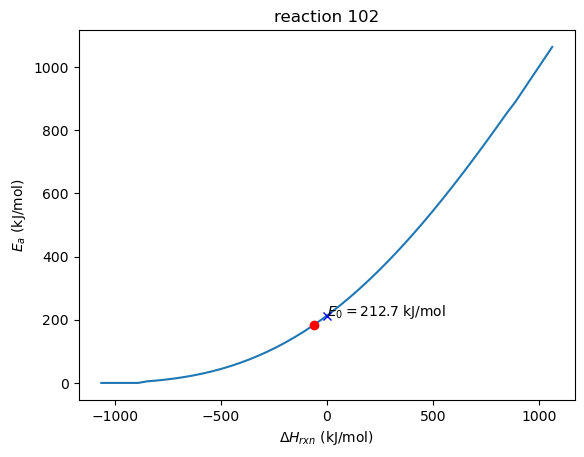

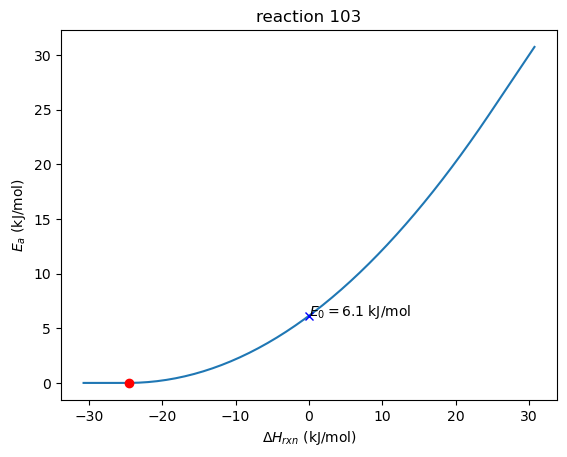

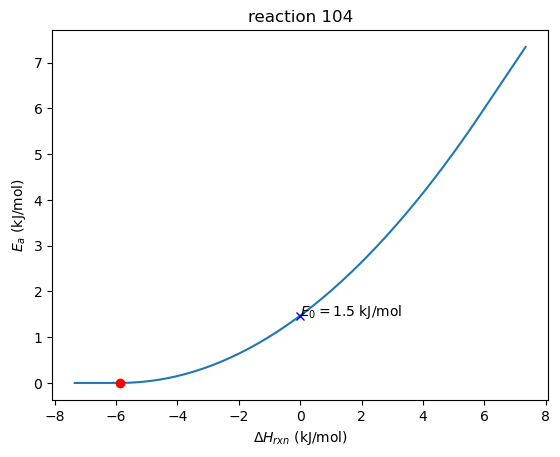

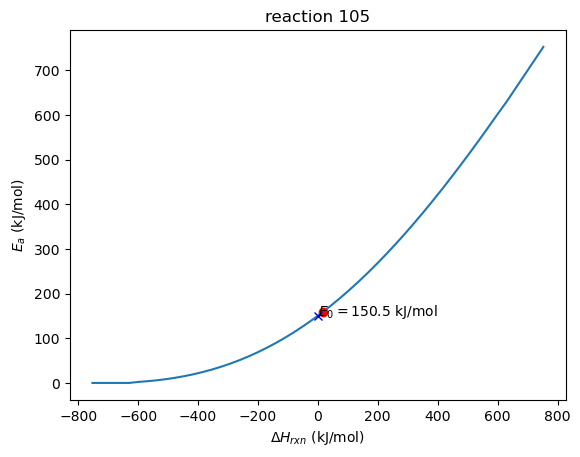

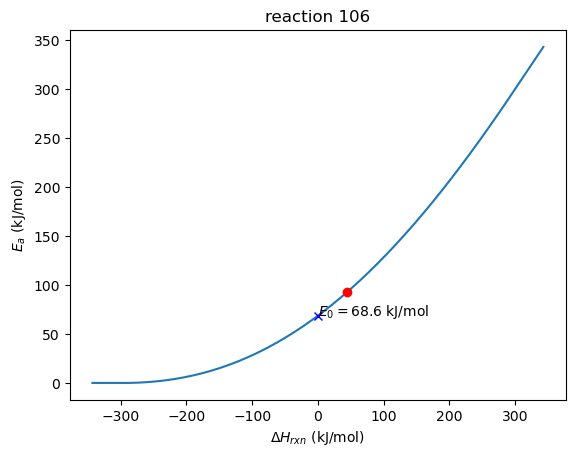

In [62]:
bm_rxns = []
for i in range(surf.n_reactions):
    model['surface1-reactions'][i]['type'] = 'Blowers-Masel'
    try:
        rc = model['surface1-reactions'][i]['rate-constant']
    except KeyError:
        rc = model['surface1-reactions'][i]['sticking-coefficient']

    Ea0 = get_E0_from_Ea_dH(i, surf.reaction(i).rate.activation_energy, surf.delta_enthalpy[i], w0=1e9, plot=True)
    rc['Ea0'] = float(Ea0)
    rc['w'] = 1e9
    del rc['Ea']
    bm_rxns.append(model['surface1-reactions'][i])

In [47]:
surf.reaction(90).rate

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_cinit',
 '_from_dict',
 '_from_parameters',
 '_reaction_rate_type',
 'activation_energy',
 'allow_negative_pre_exponential_factor',
 'beta',
 'coverage_dependencies',
 'from_dict',
 'from_yaml',
 'input_data',
 'pre_exponential_factor',
 'set_species',
 'site_density',
 'temperature_exponent',
 'type',
 'uses_electrochemistry']

In [59]:
surf.reaction(68)

CH3OH(14) + 2 X(1) <=> CH3O_X(45) + HX(21)    <Reaction(sticking-Arrhenius)>

In [56]:
surf.delta_enthalpy[68]

15639771.563425511

In [64]:
with open('base_bm/base_bm.yaml', 'w') as f:
    yaml.dump(model, f, default_flow_style=False)

In [65]:
base_path = 'base_bm/base_bm.yaml'
gas = ct.Solution(base_path, "gas")
surf = ct.Interface(base_path, 'surface1', [gas])

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in cp/R detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  10.615319744584205
	Value computed using high-temperature polynomial: 10.773680323194302

  This is separate from the ipykernel package so we can avoid doing imports until
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in h/RT detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  -16.685067677440152
	Value computed using high-temperature polynomial: -16.696975757668092

  This is separate from the ipykernel package so we can avoid doing imports until
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: NasaPoly2::validate: 
For species CH4OX(43), discontinu